[Link to Page](https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html)

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

# Load Data

In [2]:
#transforms
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = './hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
dataloader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=4,
                                   shuffle=True,
                                   num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = 'cpu'

# Data Visualization

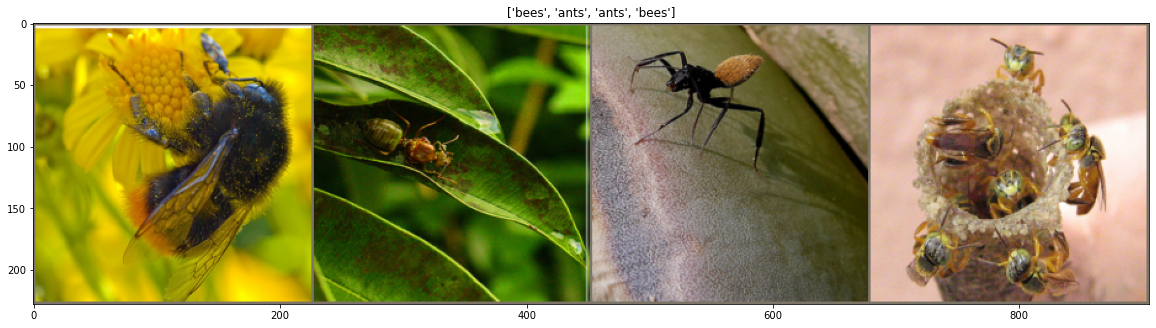

In [3]:
def imshow(inp, title = None): 
    # tensor --> (channel, H, W)
    inp = inp.numpy().transpose((1,2,0)) # --> (H, W, Channel)
    mean = np.array([0.485, 0.456,0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, [class_names[x] for x in classes])

# Train Model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print("----------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # 검증 시에는 no grad
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs)
                    _, preds = torch.max(outputs ,1)
                    #print(preds)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss/ dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wst = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print("Time : {}min {}sec".format(*divmod(time_elapsed,60)))
    print("Best val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

# Visualize Prediction

In [18]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted : {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

# Finetuning

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features # fc의 feature수
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # fc 재설정

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)


# Train & Evaluate

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6981 Acc: 0.6475
val Loss: 0.2496 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4773 Acc: 0.8197
val Loss: 0.1632 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5179 Acc: 0.7992
val Loss: 0.2423 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.5833 Acc: 0.7787
val Loss: 0.2139 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5792 Acc: 0.7459
val Loss: 0.3668 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3683 Acc: 0.8156
val Loss: 0.3487 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4086 Acc: 0.8279
val Loss: 0.4709 Acc: 0.7974

Epoch 7/24
----------
train Loss: 0.4145 Acc: 0.8443
val Loss: 0.2023 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3133 Acc: 0.8689
val Loss: 0.2197 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3973 Acc: 0.8197
val Loss: 0.2044 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3354 Acc: 0.8648
val Loss: 0.2000 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2828 Acc: 0.8607
val Loss: 0.1976 Acc: 0.9412

Ep

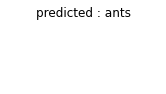

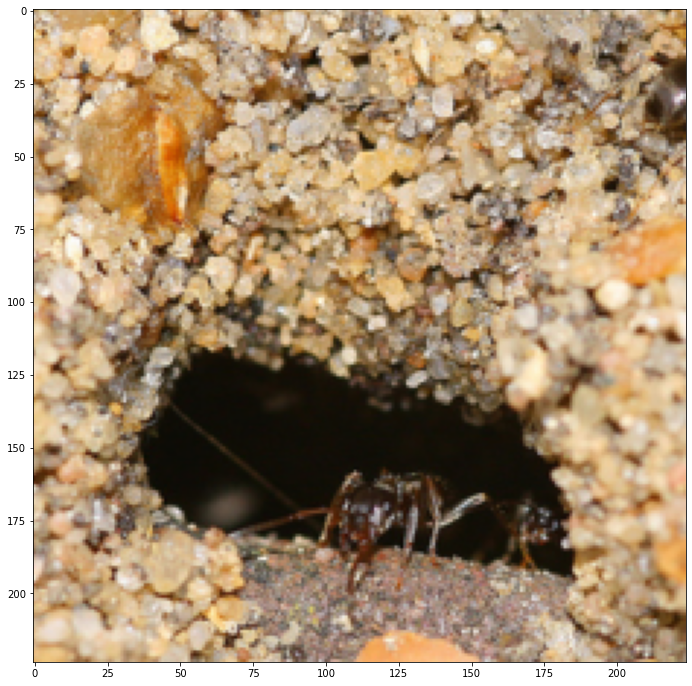

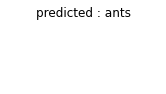

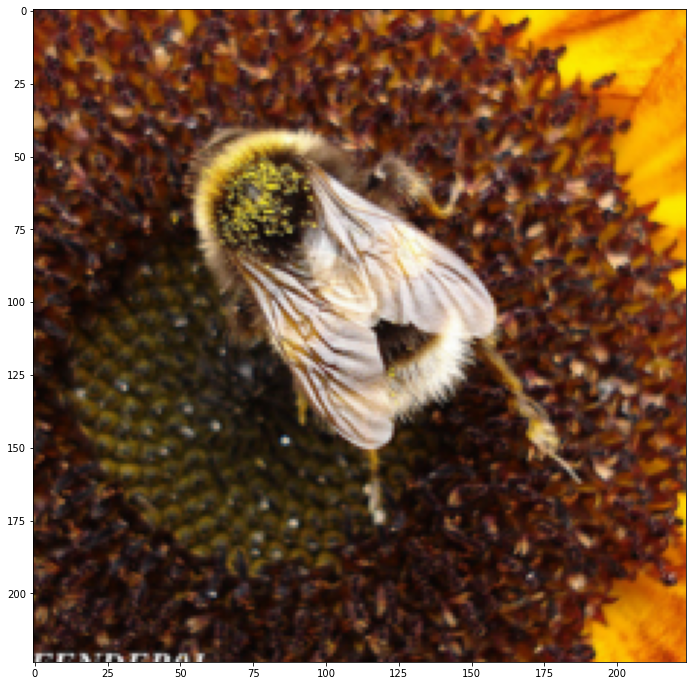

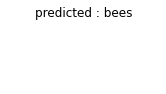

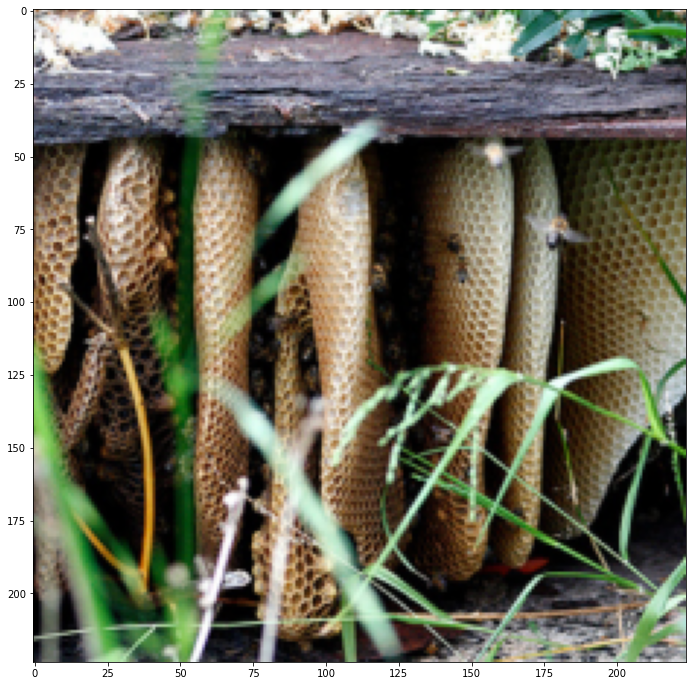

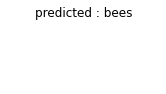

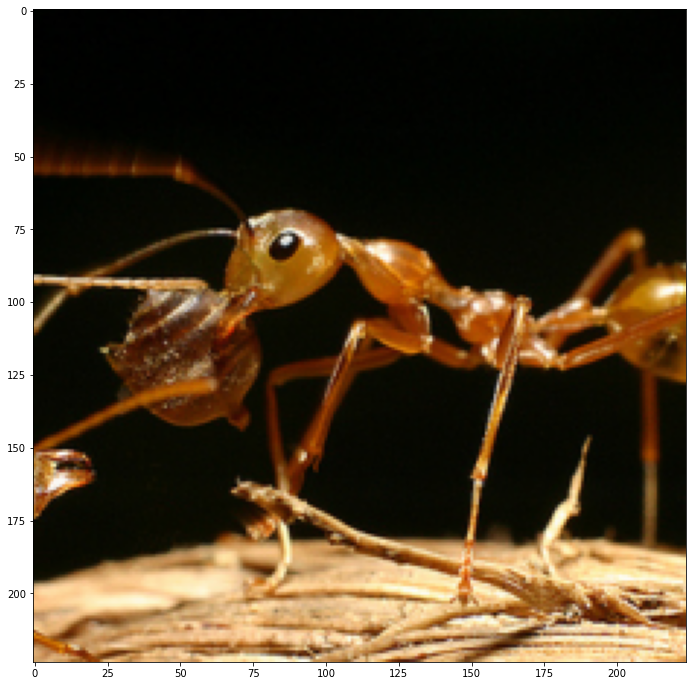

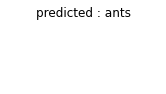

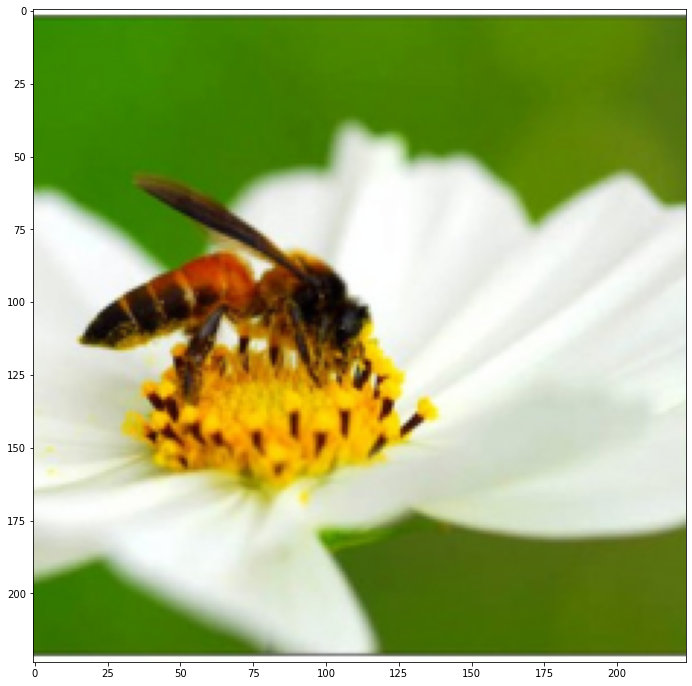

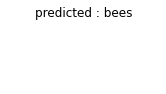

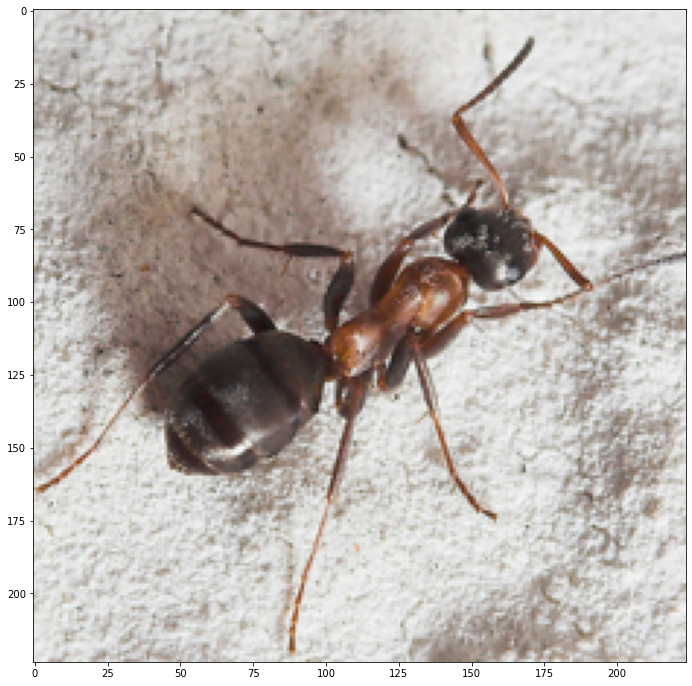

In [19]:
visualize_model(model_ft)

# Freeze

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.required_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train & Evaluate

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6609 Acc: 0.6393
val Loss: 0.2107 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5828 Acc: 0.7377
val Loss: 0.2769 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5329 Acc: 0.7623
val Loss: 0.7698 Acc: 0.7059

Epoch 3/24
----------
train Loss: 0.4371 Acc: 0.8074
val Loss: 0.1973 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4247 Acc: 0.8238
val Loss: 0.2232 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3442 Acc: 0.8361
val Loss: 0.1538 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.7628 Acc: 0.6967
val Loss: 0.5120 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.3071 Acc: 0.8648
val Loss: 0.1885 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3326 Acc: 0.8689
val Loss: 0.2027 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3383 Acc: 0.8689
val Loss: 0.1832 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3656 Acc: 0.8525
val Loss: 0.1942 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3685 Acc: 0.8402
val Loss: 0.2022 Acc: 0.9346

Ep

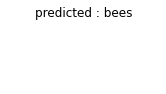

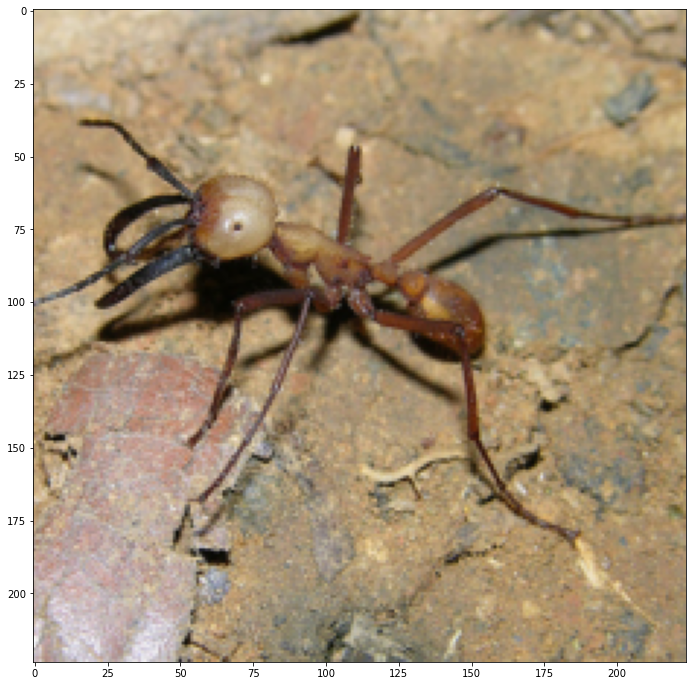

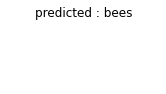

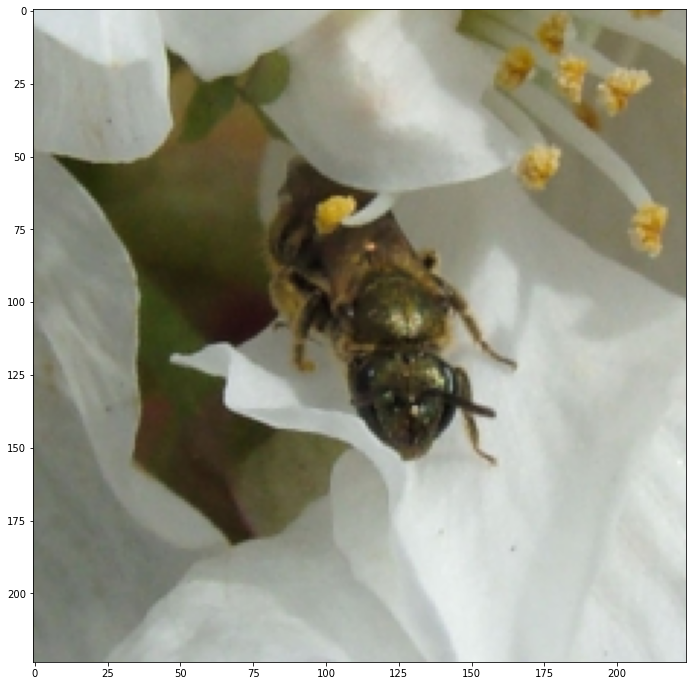

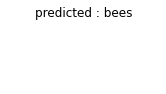

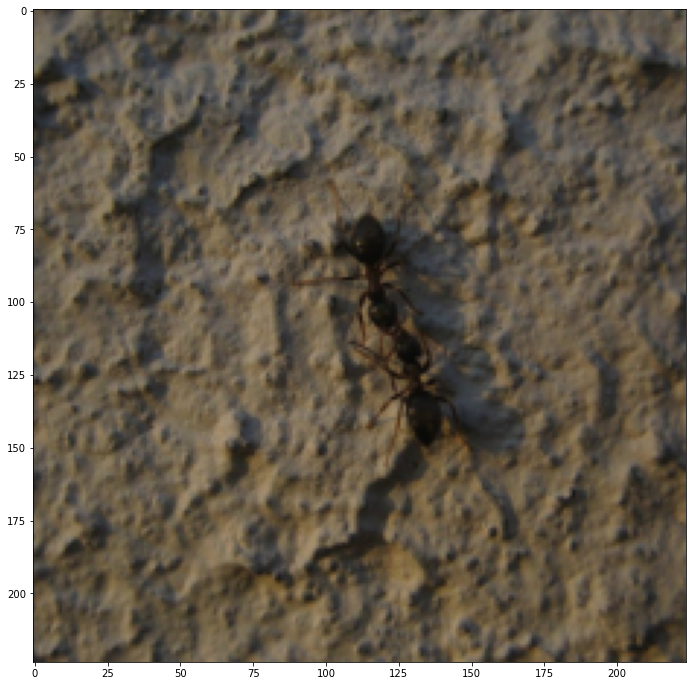

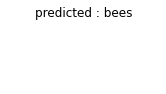

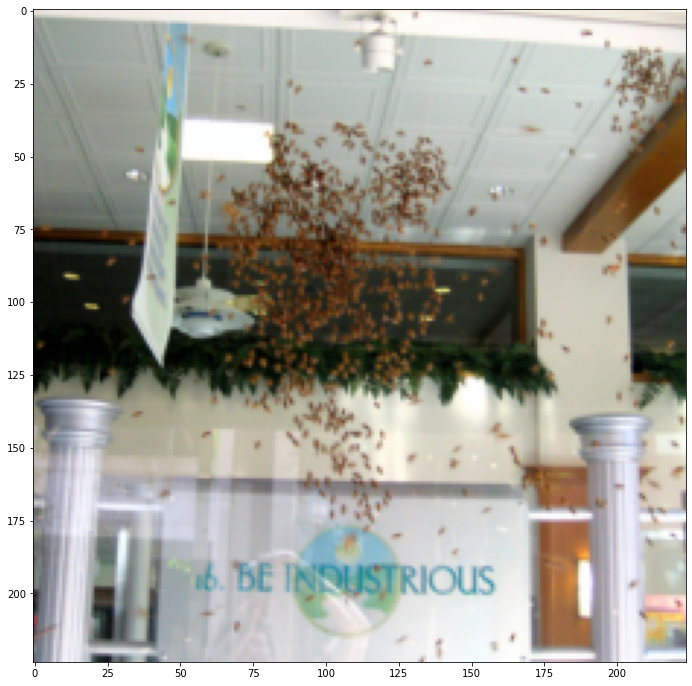

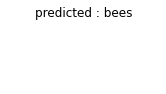

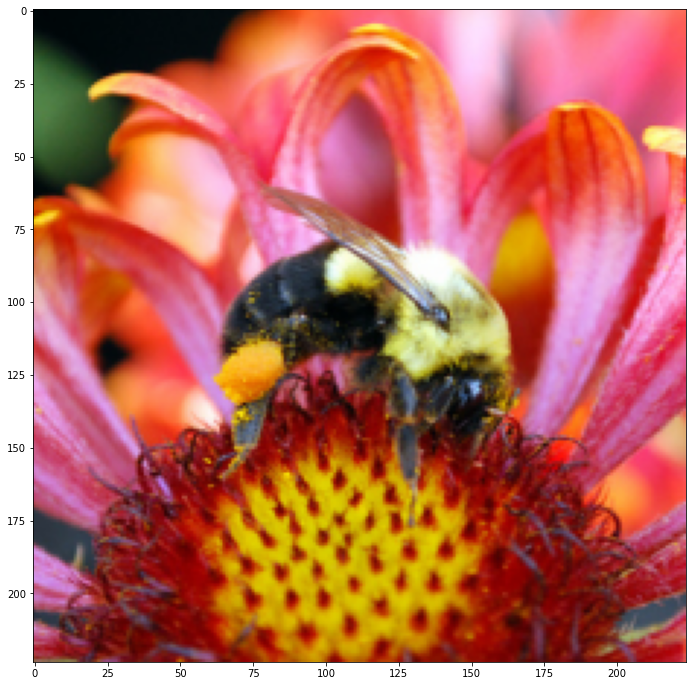

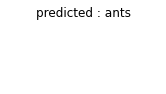

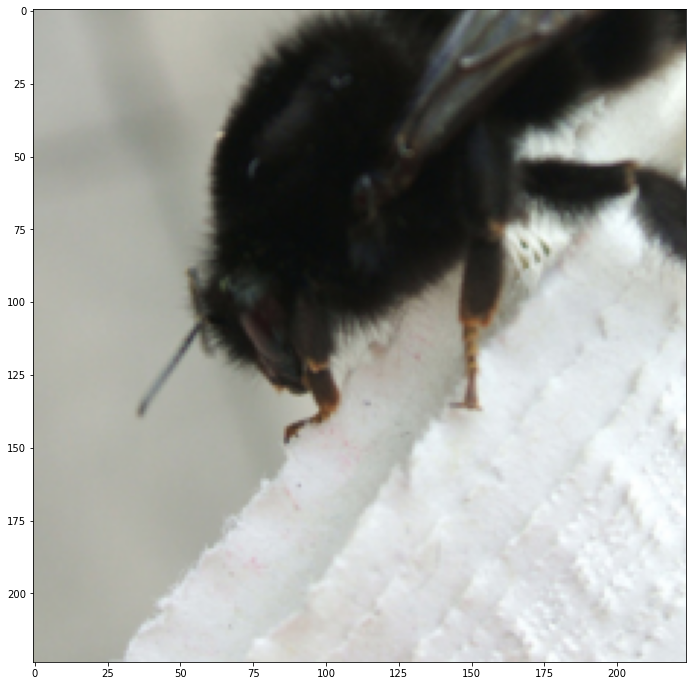

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

- Freeze 했을 때 시간 절약 효과 --> layer수가 작기도 하고 cpu라 큰 차이 없는듯,,
- 성능은 1% 차이인데 실제 효과가 있는지는 잘 모르겠다 